<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/main/notebooks/dataset_final_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Complete Dataset Generation with Feature Engineering

This notebook generates a complete dataset for precipitation prediction models including:
- Precipitation variables (CHIRPS)
- Topographic variables (DEM)
- Temporal transformations (sine/cosine of months and day of year)

Memory management techniques are used to prevent kernel issues.

This notebook is compatible with both local environments and Google Colab.

## Environment Setup

First, we detect whether we are running in Google Colab or in a local environment to configure paths and dependencies accordingly.

In [132]:
# Detect whether we are in Google Colab or local environment
import sys
import os
import subprocess

# Function to install packages
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Special function to install richdem in Colab
def install_richdem_colab():
    print("Installing richdem manually in Colab...")
    !apt-get update
    !apt-get install -y build-essential cmake libgdal-dev
    !pip install pybind11
    !git clone --recursive https://github.com/r-barnes/richdem.git
    %cd richdem/wrappers/pyRichDEM/
    !pip install .
    %cd /content
    print("✅ richdem installed successfully.")

# Check if we're in Colab
IN_COLAB = 'google.colab' in sys.modules

# Configure environment based on platform
if IN_COLAB:
    print("Running in Google Colab. Setting up environment...")

    # Install required packages
    required_packages = ['matplotlib', 'xarray', 'dask', 'netCDF4', 'psutil']
    for package in required_packages:
        try:
            __import__(package)
            print(f"✓ {package} is already installed")
        except ImportError:
            print(f"Installing {package}...")
            install_package(package)

    # Install richdem separately as it requires manual compilation
    try:
        import richdem
        print("✓ richdem is already installed")
    except ImportError:
        install_richdem_colab()

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Define base paths
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'

    # Create necessary folders if they don't exist
    for folder in ['data/output', 'models']:
        os.makedirs(os.path.join(BASE_PATH, folder), exist_ok=True)

    print(f"Base path set to: {BASE_PATH}")
    print("Colab environment configured successfully.")

else:
    print("Running in local environment.")
    BASE_PATH = '..'

    try:
        import richdem
        import xarray as xr
        import matplotlib.pyplot as plt
        import psutil

        print("✅ RichDEM and other required libraries installed successfully!")

    except ImportError as e:
        print(f"Warning: {e}")
        print("Some dependencies might be missing. Install them with pip or conda.")

print(f"Configuration completed. BASE_PATH = {BASE_PATH}")

Running in local environment.
✅ RichDEM and other required libraries installed successfully!
Configuration completed. BASE_PATH = ..


## ⚠️ Entorno Local Detectado - Aviso Importante

**¡Este notebook está siendo ejecutado en un entorno LOCAL!**

Las siguientes consideraciones son importantes:

1. **Alto consumo de recursos**: Este notebook procesa grandes conjuntos de datos geoespaciales que pueden consumir mucha memoria y CPU.
2. **Riesgo de bloqueo del sistema**: Ejecutar el proceso completo puede saturar los recursos de tu computadora.
3. **Optimización recomendada**: Si decides ejecutarlo localmente, considera:
   - Reducir la resolución espacial de los datos
   - Procesar solo un subconjunto temporal de los datos
   - Cerrar otras aplicaciones que consuman memoria

Si prefieres ejecutar el notebook completo sin problemas, considera utilizar Google Colab con acelerador de GPU y memoria RAM adicional.

In [133]:
# Esta celda solo se debe ejecutar en Google Colab
if IN_COLAB:  # Verificamos si estamos en Colab antes de ejecutar
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Ejecución omitida: No es necesario montar Google Drive en un entorno local.")

Ejecución omitida: No es necesario montar Google Drive en un entorno local.


In [134]:
# Required imports
import numpy as np
import pandas as pd
import xarray as xr
import richdem as rd
import gc
import psutil
import os
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

# Configure xarray to work with dask for parallel processing
import dask
from dask.diagnostics import ProgressBar

# Suppress warnings
warnings.filterwarnings('ignore')

# Display configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [135]:
# Function to check memory usage
def check_memory_usage():
    """Displays current memory usage and suggests possible actions."""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    # Convert to MB for better readability
    memory_usage_mb = memory_info.rss / 1024 / 1024
    virtual_memory = psutil.virtual_memory()
    available_mb = virtual_memory.available / 1024 / 1024
    total_mb = virtual_memory.total / 1024 / 1024
    used_percentage = virtual_memory.percent

    print(f"\n--- Memory Usage ---")
    print(f"Memory used by this process: {memory_usage_mb:.1f} MB")
    print(f"Total available memory: {available_mb:.1f} MB of {total_mb:.1f} MB ({used_percentage:.1f}%)")

    # Suggest actions based on memory usage
    if used_percentage > 85:
        print("WARNING: Critical memory usage! Recommended actions:")
        print("  - Free unnecessary variables (use 'del variable')")
        print("  - Run gc.collect() to release memory")
        print("  - Reduce chunk size")
        print("  - Save intermediate results and restart the kernel")
    elif used_percentage > 70:
        print("ATTENTION: High memory usage. Consider freeing unused variables.")
    else:
        print("Normal memory usage.")

    return memory_usage_mb, available_mb, used_percentage

In [136]:
# Helper class to monitor progress
class DatasetGenerator:
    """Helper class to generate and monitor the complete dataset."""

    @staticmethod
    def monitor_computation(func):
        """Decorator to monitor computation progress."""
        def wrapper(*args, **kwargs):
            print(f"Starting: {func.__name__}")
            check_memory_usage()
            start_time = datetime.now()

            with ProgressBar():
                result = func(*args, **kwargs)

            end_time = datetime.now()
            duration = end_time - start_time
            print(f"Completed: {func.__name__} in {duration}")
            check_memory_usage()
            return result
        return wrapper

    @staticmethod
    def plot_sample(dataset, var_name, time_index=0):
        """Visualize a sample from the dataset."""
        plt.figure(figsize=(10, 8))

        if 'time' in dataset[var_name].dims:
            # Variable with time dimension
            data = dataset[var_name].isel(time=time_index)
            title = f"{var_name} - {pd.Timestamp(dataset.time.values[time_index]).strftime('%Y-%m-%d')}"
        else:
            # Variable without time dimension
            data = dataset[var_name]
            title = f"{var_name}"

        # Create heatmap
        im = plt.imshow(data, cmap='viridis')
        plt.colorbar(im, label=var_name)
        plt.title(title)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(False)
        plt.show()

        # Show basic statistics
        stats = {
            'min': float(data.min().values),
            'max': float(data.max().values),
            'mean': float(data.mean().values),
            'std': float(data.std().values)
        }
        print(f"Statistics for {var_name}:")
        for k, v in stats.items():
            print(f"  {k}: {v:.4f}")

## 1. Loading Precipitation and Elevation Data

In [137]:
import os
import xarray as xr
import numpy as np
import psutil

# ---------------------------------------------------------------
# Dynamic CHUNK_SIZE configuration based on available memory
# ---------------------------------------------------------------

def get_optimal_chunk_size():
    """Defines the optimal chunk size according to the available RAM"""
    mem = psutil.virtual_memory()
    total_gb = mem.total / (1024 ** 3)  # Convert bytes to GB
    print(f"🧠 Total memory detected: {total_gb:.2f} GB")

    if total_gb < 8:
        return {'time': 10, 'latitude': 50, 'longitude': 50}
    elif total_gb < 16:
        return {'time': 20, 'latitude': 100, 'longitude': 100}
    elif total_gb < 32:
        return {'time': 30, 'latitude': 200, 'longitude': 200}
    else:
        return {'time': 40, 'latitude': 300, 'longitude': 300}

# Assign CHUNK_SIZE
CHUNK_SIZE = get_optimal_chunk_size()
print(f"🔧 Chunk size configured: {CHUNK_SIZE}")

# ---------------------------------------------------------------
# Path definitions
# ---------------------------------------------------------------

# BASE_PATH should be defined previously
chirps_path = os.path.join(BASE_PATH, 'data/output/boyaca_region_daily.nc')
dem_path = os.path.join(BASE_PATH, 'data/output/dem_boyaca_90.nc')

output_directory = os.path.join(BASE_PATH, 'data/output')
output_path = os.path.join(output_directory, 'complete_dataset_with_features.nc')

# Create output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"📁 Directory created: {output_directory}")
else:
    print(f"📁 Output directory exists: {output_directory}")

# Verify file existence
for file_path in [chirps_path, dem_path]:
    if os.path.exists(file_path):
        print(f"✅ File found: {file_path}")
    else:
        print(f"⚠️ WARNING: File not found: {file_path}")

# ---------------------------------------------------------------
# Function to print dataset statistics
# ---------------------------------------------------------------

def describe_dataset(ds, name="Dataset"):
    """Prints a summary of an xarray dataset"""
    print(f"\n📄 Statistics for {name}:")
    print(f"- Dimensions: {dict(ds.dims)}")

    # Coordinate statistics
    for coord in ['latitude', 'longitude']:
        if coord in ds.coords:
            coord_values = ds.coords[coord].values
            print(f"  ◦ {coord}: min={np.min(coord_values):.4f}, max={np.max(coord_values):.4f}, std={np.std(coord_values):.4f}")

    # Variable statistics
    print(f"- Variables:")
    for var in ds.data_vars:
        data = ds[var].values
        if np.issubdtype(data.dtype, np.number):
            print(f"  • {var}: min={np.nanmin(data):.4f}, max={np.nanmax(data):.4f}, mean={np.nanmean(data):.4f}, std={np.nanstd(data):.4f}")
        else:
            print(f"  • {var}: data type {data.dtype}")

# ---------------------------------------------------------------
# Load datasets applying chunks
# ---------------------------------------------------------------

# Load CHIRPS
print("\n📥 Loading CHIRPS dataset...")
chirps_ds = xr.open_dataset(chirps_path, chunks=CHUNK_SIZE)
describe_dataset(chirps_ds, "CHIRPS")

# Load DEM
print("\n📥 Loading DEM dataset...")
dem_chunks = {k: v for k, v in CHUNK_SIZE.items() if k in ['latitude', 'longitude']}
dem_ds = xr.open_dataset(dem_path, chunks=dem_chunks)
describe_dataset(dem_ds, "DEM")


🧠 Total memory detected: 16.00 GB
🔧 Chunk size configured: {'time': 30, 'latitude': 200, 'longitude': 200}
📁 Output directory exists: ../data/output
✅ File found: ../data/output/boyaca_region_daily.nc
✅ File found: ../data/output/dem_boyaca_90.nc

📥 Loading CHIRPS dataset...

📄 Statistics for CHIRPS:
- Dimensions: {'time': 16130, 'latitude': 62, 'longitude': 66}
  ◦ latitude: min=4.3250, max=7.3750, std=0.8948
  ◦ longitude: min=-74.9750, max=-71.7250, std=0.9525
- Variables:
  • precip: min=0.0000, max=380.8983, mean=6.1375, std=11.3565

📥 Loading DEM dataset...

📄 Statistics for DEM:
- Dimensions: {'latitude': 4800, 'longitude': 7200}
  ◦ latitude: min=4.0013, max=8.0004, std=1.1547
  ◦ longitude: min=-76.0004, max=-70.0013, std=1.7321
- Variables:
  • DEM: min=18.0000, max=5327.0000, mean=961.1704, std=1048.0789


Iniciando generación del dataset completo...

--- Memory Usage ---
Memory used by this process: 410.6 MB
Total available memory: 3241.3 MB of 16384.0 MB (80.2%)
ATTENTION: High memory usage. Consider freeing unused variables.

1. Cargando datos con chunks...
CHIRPS cargado: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 62, 'longitude': 66})

--- Memory Usage ---
Memory used by this process: 413.1 MB
Total available memory: 3238.8 MB of 16384.0 MB (80.2%)
ATTENTION: High memory usage. Consider freeing unused variables.
DEM cargado: FrozenMappingWarningOnValuesAccess({'latitude': 4800, 'longitude': 7200})

--- Memory Usage ---
Memory used by this process: 419.5 MB
Total available memory: 3234.7 MB of 16384.0 MB (80.3%)
ATTENTION: High memory usage. Consider freeing unused variables.

2. Identificando variable de precipitación en CHIRPS...
Variable encontrada: precip
Usando precip como variable de precipitación

3. Alineando coordenadas DEM con CHIRPS...
Interpolando DEM 

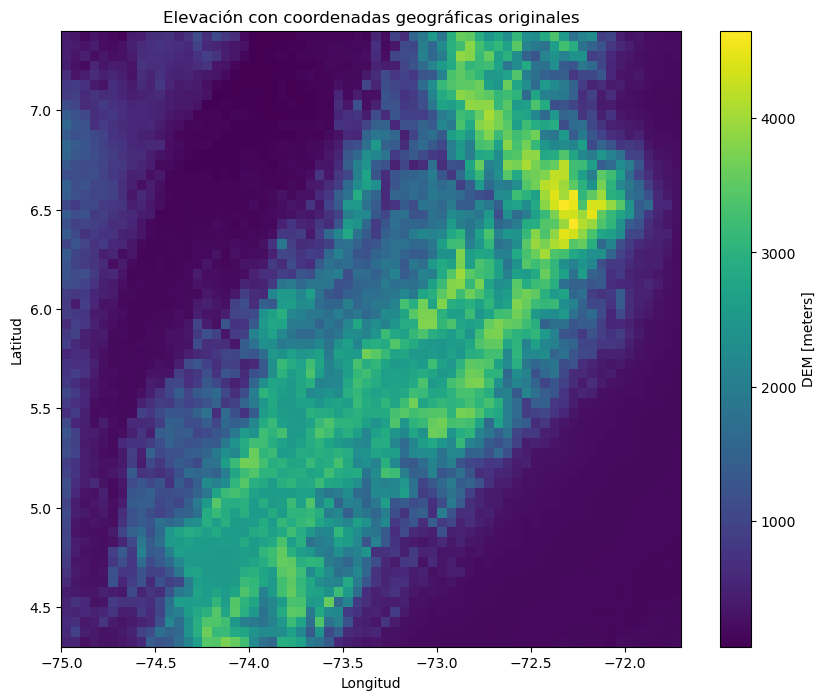

In [138]:
def compute_slope_aspect(elevation_array, cellsize=1):
    """
    Calculate slope and aspect from an elevation array.
    
    Parameters:
    -----------
    elevation_array : numpy.ndarray
        The elevation data as a 2D array
    cellsize : float
        The cell size for gradient calculation
        
    Returns:
    --------
    slope : numpy.ndarray
        Slope in degrees
    aspect : numpy.ndarray
        Aspect in degrees (0-360, clockwise from North)
    """
    grad_y, grad_x = np.gradient(elevation_array, cellsize)
    slope = np.sqrt(grad_x**2 + grad_y**2)
    slope = np.arctan(slope) * (180/np.pi)
    aspect = np.arctan2(-grad_x, grad_y) * (180/np.pi)
    aspect = np.where(aspect < 0, 90.0 - aspect, 360.0 - aspect + 90.0)
    aspect = np.mod(aspect, 360.0)
    return slope, aspect


def generate_complete_dataset(chirps_path, dem_path, output_path, chunk_size=20):
    """
    Genera un dataset completo con variables artificiales de elevación, precipitación,
    y transformaciones temporales (seno/coseno de meses y año).
    Utiliza chunks y técnicas de gestión de memoria para prevenir fallos en el kernel.

    Parameters:
    -----------
    chirps_path : str
        Ruta al dataset CHIRPS
    dem_path : str
        Ruta al dataset DEM
    output_path : str
        Ruta donde se guardará el dataset final
    chunk_size : int
        Tamaño de los chunks para procesamiento
    """
    try:
        print("Iniciando generación del dataset completo...")
        check_memory_usage()
        
        # 1. Cargar datos con chunks para optimizar memoria
        print("\n1. Cargando datos con chunks...")
        chirps_chunks = {'latitude': chunk_size, 'longitude': chunk_size, 'time': -1}
        dem_chunks = {'latitude': chunk_size, 'longitude': chunk_size}

        chirps_ds = xr.open_dataset(chirps_path, chunks=chirps_chunks)
        print(f"CHIRPS cargado: {chirps_ds.dims}")
        check_memory_usage()

        dem_ds = xr.open_dataset(dem_path, chunks=dem_chunks)
        print(f"DEM cargado: {dem_ds.dims}")
        check_memory_usage()

        # 2. Identificar la variable de precipitación en CHIRPS
        print("\n2. Identificando variable de precipitación en CHIRPS...")
        precip_var = None
        for var_name in chirps_ds.data_vars:
            print(f"Variable encontrada: {var_name}")
            precip_var = var_name
            break

        if not precip_var:
            raise ValueError("No se encontró ninguna variable de datos en CHIRPS")

        print(f"Usando {precip_var} como variable de precipitación")

        # 3. Alinear coordenadas - interpolando DEM a la resolución de CHIRPS
        print("\n3. Alineando coordenadas DEM con CHIRPS...")

        # Verificar si las dimensiones no coinciden
        if dem_ds.sizes['longitude'] != chirps_ds.sizes['longitude'] or dem_ds.sizes['latitude'] != chirps_ds.sizes['latitude']:
            print("Interpolando DEM a la resolución de CHIRPS...")
            dem_ds = dem_ds.interp(
                longitude=chirps_ds.longitude,
                latitude=chirps_ds.latitude,
                method='linear',  # Interpolación bilineal
                kwargs={"fill_value": "extrapolate"}  # Evitar NaNs en bordes
            )
            print("Interpolación completada.")

        # Reasignar las coordenadas para garantizar origen y pasos iguales
        print("Corrigiendo origen y alineación de coordenadas...")
        dem_ds = dem_ds.assign_coords(
            longitude=chirps_ds.longitude,
            latitude=chirps_ds.latitude
        )
        print("Coordenadas de origen alineadas perfectamente.")

        check_memory_usage()

        # 4. Crear variables derivadas del tiempo (mes/año)
        print("\n4. Generando variables temporales (seno/coseno)...")

        # Extraer tiempo como dataframe para facilitar manipulación
        print("Extrayendo fechas del dataset...")
        times = pd.to_datetime(chirps_ds.time.values)
        months = times.month
        years = times.year
        days_in_year = 365.25

        # Crear variables cíclicas para mes (periodo = 12)
        print("Calculando seno/coseno de meses...")
        month_sin = np.sin(2 * np.pi * months / 12)
        month_cos = np.cos(2 * np.pi * months / 12)

        # Crear variables cíclicas para día del año (periodo = 365.25)
        print("Calculando seno/coseno del día del año...")
        day_of_year = times.dayofyear
        doy_sin = np.sin(2 * np.pi * day_of_year / days_in_year)
        doy_cos = np.cos(2 * np.pi * day_of_year / days_in_year)

        # 5. Extraer la variable de elevación del DEM
        print("\n5. Extrayendo variables de elevación del DEM...")
        # Correcto para mantener las coordenadas
        elevation = dem_ds[list(dem_ds.data_vars)[0]]
        print("Graficando elevación con coordenadas reales...")
        plt.figure(figsize=(10, 8))
        elevation.plot(cmap='viridis')
        plt.title('Elevación con coordenadas geográficas originales')
        plt.xlabel('Longitud')
        plt.ylabel('Latitud')
        
        # 6. Calcular variables topográficas usando método de gradientes
        print("\n6. Calculando características topográficas usando método de gradientes...")

        # Procesar por bloques para evitar problemas de memoria
        print("Preparando cálculo de pendiente y aspecto...")
        dem_data = elevation.values

        # Verificar si hay valores NaN y reemplazarlos con un valor NoData
        nan_mask = np.isnan(dem_data)
        if nan_mask.any():
            print(f"Encontrados {nan_mask.sum()} valores NaN en DEM, reemplazando con NoData")
            dem_data_clean = np.copy(dem_data)
            dem_data_clean[nan_mask] = -9999  # Valor NoData para procesamiento
        else:
            dem_data_clean = dem_data

        print("Calculando pendiente y aspecto usando gradientes...")
        slope, aspect = compute_slope_aspect(dem_data_clean)
        slope = slope.astype(np.float32)
        aspect = aspect.astype(np.float32)

        # Restaurar NaNs
        if np.isnan(dem_data).any():
            slope[np.isnan(dem_data)] = np.nan
            aspect[np.isnan(dem_data)] = np.nan

        gc.collect()
        check_memory_usage()

        # 7. Calcular variables mensuales de precipitación
        print("\n7. Calculando estadísticas mensuales de precipitación...")

        # Crear dataset con todas las variables derivadas
        print("\n8. Creando dataset final con todas las variables...")

        # Iniciar con un dataset vacío
        ds_final = xr.Dataset(
            coords={
                'time': chirps_ds.time,
                'latitude': chirps_ds.latitude,
                'longitude': chirps_ds.longitude
            }
        )

        # Agregar precipitación original
        print("Agregando precipitación original...")
        ds_final['precipitation'] = chirps_ds[precip_var]

        # Liberar memoria de chirps_ds si ya no se necesita
        chirps_data = chirps_ds[precip_var].values
        chirps_ds.close()
        del chirps_ds
        gc.collect()
        check_memory_usage()

        # Calcular estadísticas mensuales de precipitación
        print("Calculando total de precipitación mensual...")
        # Agrupar por año y mes
        dates_pd = pd.DataFrame({'time': times, 'month': months, 'year': years})
        unique_year_months = dates_pd.drop_duplicates(['year', 'month'])[['year', 'month']].values

        # Inicializar arrays para las estadísticas mensuales
        lat_dim = len(ds_final.latitude)
        lon_dim = len(ds_final.longitude)
        time_dim = len(unique_year_months)  # Número de meses únicos

        monthly_total = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)
        monthly_max = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)
        monthly_min = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)
        monthly_std = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)

        # Crear array para las fechas mensuales
        monthly_dates = []

        # Procesar mes por mes para evitar problemas de memoria
        print(f"Procesando {len(unique_year_months)} meses únicos...")
        for i, (year, month) in enumerate(unique_year_months):
            if i % 10 == 0:
                print(f"Procesando mes {i+1}/{len(unique_year_months)}: {year}-{month:02d}")

            # Filtrar fechas para este mes
            month_indices = np.where((years == year) & (months == month))[0]
            month_data = chirps_data[month_indices]

            # Calcular estadísticas
            monthly_total[i] = np.sum(month_data, axis=0)
            monthly_max[i] = np.max(month_data, axis=0)
            monthly_min[i] = np.min(month_data, axis=0)
            monthly_std[i] = np.std(month_data, axis=0)

            # Añadir fecha (primer día del mes)
            monthly_dates.append(np.datetime64(f"{year}-{month:02d}-01"))

        # Asegurar que monthly_dates se convierte correctamente a un array numpy
        if len(monthly_dates) > 0:
            monthly_time = np.array(monthly_dates, dtype='datetime64[ns]')
        else:
            raise ValueError("monthly_dates está vacío. Asegúrate de que el bucle que procesa los meses únicos lo está llenando correctamente.")

        # Liberar memoria
        del chirps_data
        gc.collect()
        check_memory_usage()

        # Añadir variables mensuales al dataset
        print("Agregando variables mensuales al dataset...")
        ds_monthly = xr.Dataset(
            data_vars={
                'total_precipitation': xr.DataArray(
                    monthly_total,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'max_daily_precipitation': xr.DataArray(
                    monthly_max,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'min_daily_precipitation': xr.DataArray(
                    monthly_min,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'daily_precipitation_std': xr.DataArray(
                    monthly_std,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                )
            }
        )

        # Liberar memoria de arrays intermedios
        del monthly_total, monthly_max, monthly_min, monthly_std
        gc.collect()
        check_memory_usage()

        # Añadir variables cíclicas de tiempo
        print("Agregando variables cíclicas de tiempo...")

        # Extraer mes y año para las fechas mensuales
        monthly_dates_pd = pd.DatetimeIndex(monthly_time)
        monthly_month = monthly_dates_pd.month
        monthly_doy = monthly_dates_pd.dayofyear

        # Calcular seno y coseno para meses
        month_sin_monthly = np.sin(2 * np.pi * monthly_month / 12)
        month_cos_monthly = np.cos(2 * np.pi * monthly_month / 12)

        # Calcular seno y coseno para día del año
        doy_sin_monthly = np.sin(2 * np.pi * monthly_doy / days_in_year)
        doy_cos_monthly = np.cos(2 * np.pi * monthly_doy / days_in_year)

        # Crear arrays 3D usando numpy directamente en lugar de broadcast_to
        print("Creando arrays 3D para variables cíclicas...")
        time_size = len(monthly_time)

        # Inicializar arrays vacíos
        month_sin_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)
        month_cos_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)
        doy_sin_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)
        doy_cos_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)

        # Llenar los arrays manualmente para evitar problemas de memoria
        for t in range(time_size):
            # Asignar el mismo valor a toda la slice de tiempo
            month_sin_3d[t, :, :] = month_sin_monthly[t]
            month_cos_3d[t, :, :] = month_cos_monthly[t]
            doy_sin_3d[t, :, :] = doy_sin_monthly[t]
            doy_cos_3d[t, :, :] = doy_cos_monthly[t]

            # Liberar memoria cada cierto número de iteraciones
            if t > 0 and t % 50 == 0:
                gc.collect()
                print(f"Procesados {t}/{time_size} pasos de tiempo para variables cíclicas")

        # Crear DataArrays con los arrays 3D ya inicializados
        ds_monthly['month_sin'] = xr.DataArray(
            month_sin_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        ds_monthly['month_cos'] = xr.DataArray(
            month_cos_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        ds_monthly['doy_sin'] = xr.DataArray(
            doy_sin_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        ds_monthly['doy_cos'] = xr.DataArray(
            doy_cos_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        # Liberar memoria de los arrays temporales
        del month_sin_monthly, month_cos_monthly, doy_sin_monthly, doy_cos_monthly
        del month_sin_3d, month_cos_3d, doy_sin_3d, doy_cos_3d
        gc.collect()
        check_memory_usage()

        # Añadir variables topográficas
        print("Agregando variables topográficas...")
        ds_topo = xr.Dataset(
            data_vars={
                'elevation': xr.DataArray(
                    elevation.values,
                    dims=['latitude', 'longitude'],
                    coords={'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'slope': xr.DataArray(
                    slope,
                    dims=['latitude', 'longitude'],
                    coords={'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'aspect': xr.DataArray(
                    aspect,
                    dims=['latitude', 'longitude'],
                    coords={'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                )
            }
        )

        # Liberar memoria
        del elevation, slope, aspect
        gc.collect()
        check_memory_usage()

        # Combinar datasets (mensual y topo)
        print("\n9. Combinando datasets...")
        final_combined = xr.merge([ds_monthly, ds_topo])

        # Añadir metadatos
        final_combined.attrs['description'] = 'ST-HyMOUNTAIN-Net ready dataset with CHIRPS monthly precipitation and DEM variables'
        final_combined.attrs['source'] = 'CHIRPS v2.0 & DEM Boyacá'
        final_combined.attrs['created_at'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # Configurar chunks óptimos para el almacenamiento
        print("\n10. Configurando chunks para almacenamiento eficiente...")
        encoding = {var: {'zlib': True, 'complevel': 5} for var in final_combined.data_vars}

        # Guardar el dataset resultante
        print(f"\n11. Guardando dataset final en {output_path}...")
        final_combined.to_netcdf(
            output_path,
            encoding=encoding,
            compute=True  # Fuerza la computación ahora
        )

        print(f"\nDataset generado y guardado exitosamente en {output_path}")
        print("Dimensiones finales del dataset:")
        print(f"- Variables: {list(final_combined.data_vars)}")
        print(f"- Dimensiones: {dict(final_combined.dims)}")

        # Verificar uso final de memoria
        check_memory_usage()

        return final_combined

    except Exception as e:
        print(f"Error generando dataset completo: {e}")
        import traceback
        traceback.print_exc()
        return None
    finally:
        # Asegurarse de liberar toda la memoria
        gc.collect()
        check_memory_usage()

# Ejecutar la generación del dataset completo
# Ya definimos estas rutas arriba usando BASE_PATH
# chirps_path, dem_path y output_path ya están definidos

# Ejecutar con manejo de excepciones
try:
    complete_dataset = generate_complete_dataset(
        chirps_path=chirps_path,
        dem_path=dem_path,
        output_path=output_path,
        chunk_size=CHUNK_SIZE['longitude']  # Usar el tamaño de chunk definido anteriormente
    )

    if complete_dataset is not None:
        print("\nGeneración del dataset completada con éxito.")
        print("Para visualizar los resultados, cargue el dataset desde el archivo guardado.")
        plt.show()  # Mostrar gráficos al final
except Exception as e:
    print(f"Error ejecutando la generación del dataset: {e}")

## 2. Visualization of Results

Now we'll load the generated dataset and visualize some of the variables to verify that everything has been correctly generated.


✅ Dataset loaded successfully.

Dataset summary:
- Variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'elevation', 'slope', 'aspect']
- Dimensions: {'time': 530, 'latitude': 62, 'longitude': 66}
- Coordinates: ['time', 'latitude', 'longitude']

Latitudes: min=4.3250, max=7.3750, std=0.8948
Longitudes: min=-74.9750, max=-71.7250, std=0.9525

📈 Statistics for total_precipitation:
  - Minimum: 0.0000
  - Maximum: 1265.9023
  - Mean: 186.7885
  - Standard deviation: 126.3278

📈 Statistics for max_daily_precipitation:
  - Minimum: 0.0000
  - Maximum: 380.8983
  - Mean: 35.6783
  - Standard deviation: 21.1726

📈 Statistics for min_daily_precipitation:
  - Minimum: 0.0000
  - Maximum: 5.5219
  - Mean: 0.0000
  - Standard deviation: 0.0098

📈 Statistics for daily_precipitation_std:
  - Minimum: 0.0000
  - Maximum: 69.5311
  - Mean: 9.2190
  - Standard deviation: 5.1672

📈 Statistic

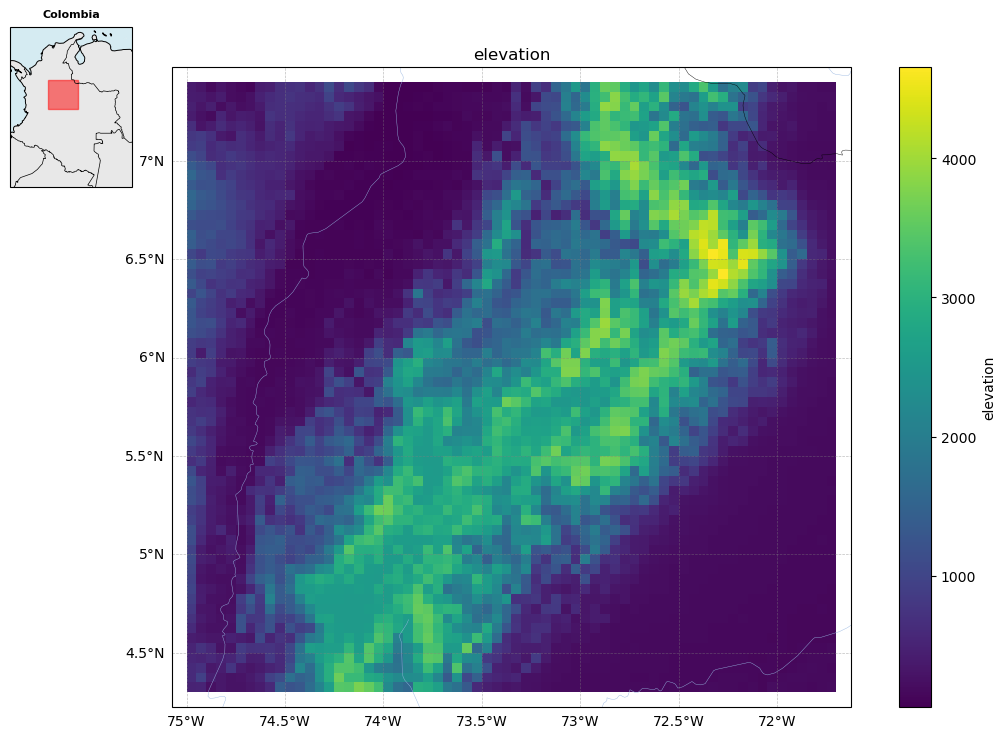

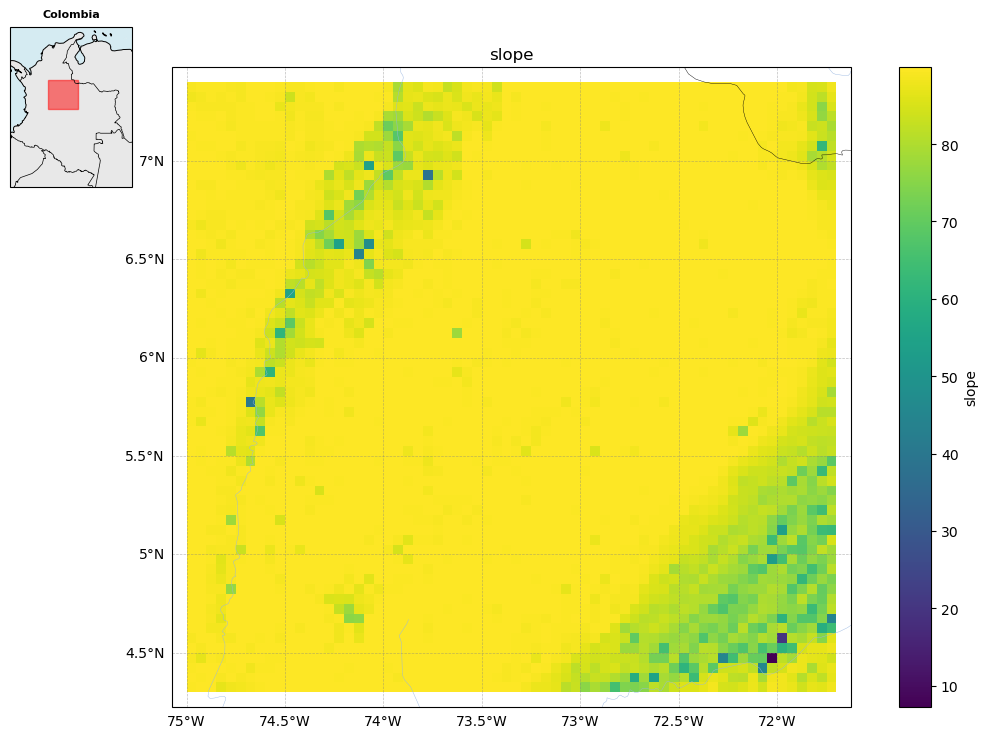

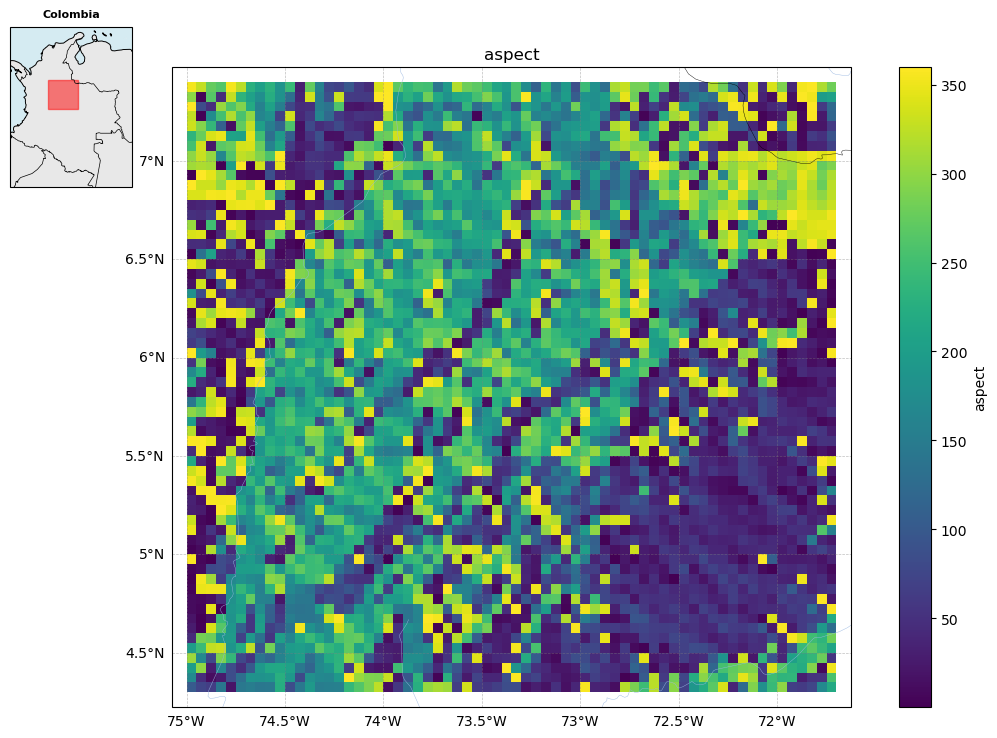


Visualizando variables de precipitación (índice de tiempo: 265)...


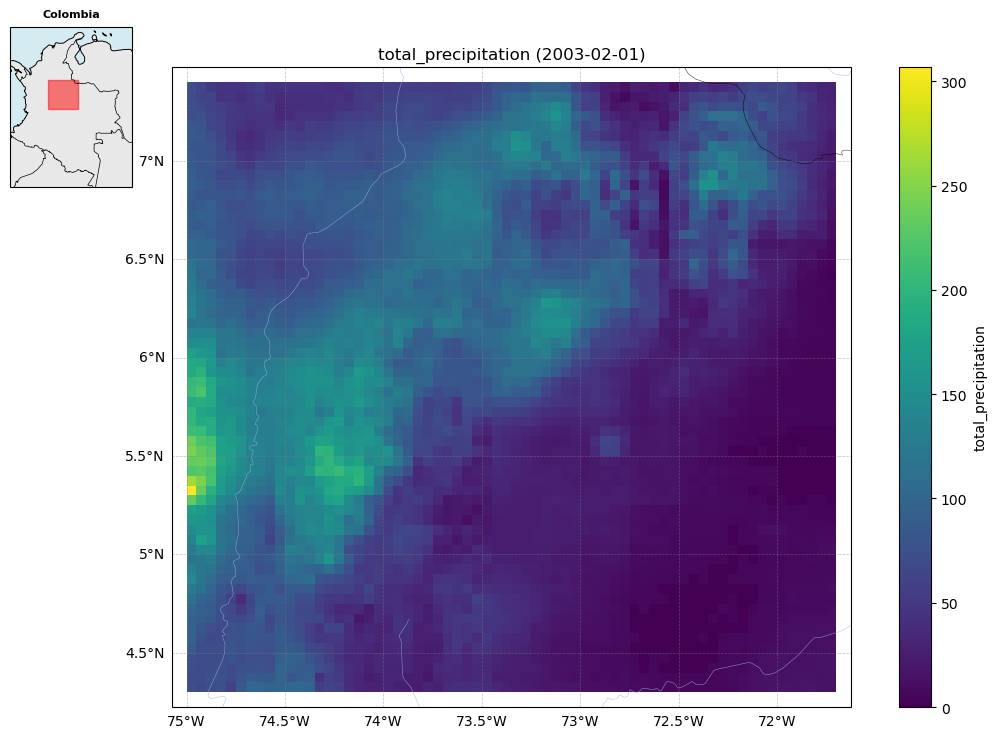

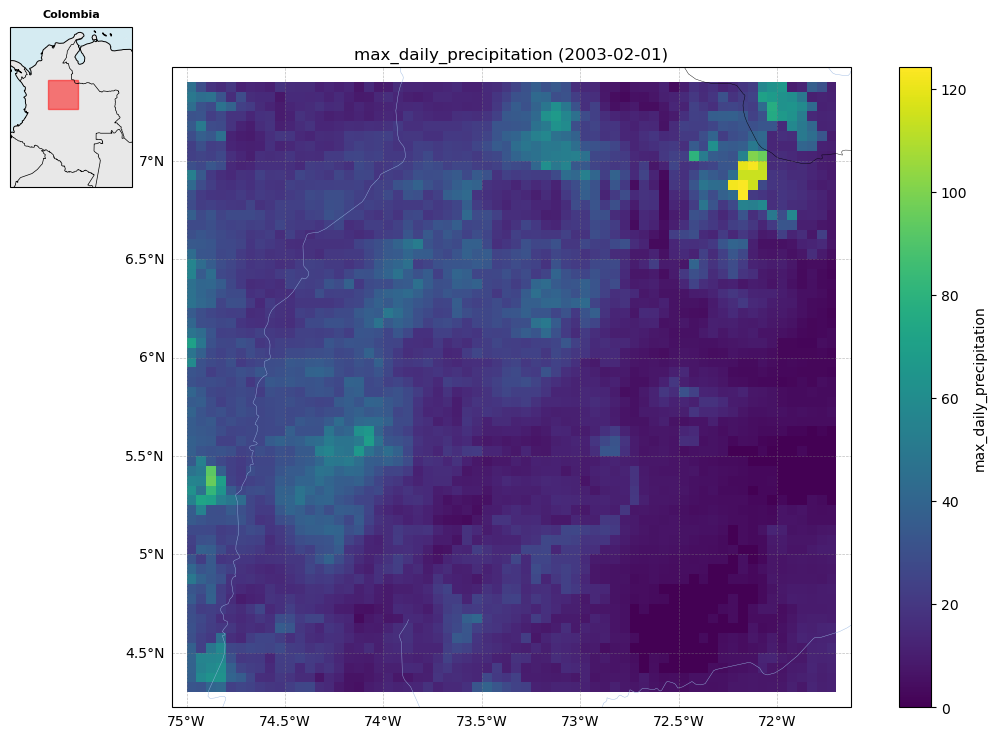

In [139]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner as gridliner
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

# ---------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------

def plot_variable(dataset, var_name, time_index=None):
    """Plot a variable from the dataset"""
    data = dataset[var_name]

    if 'time' in data.dims:
        if time_index is None:
            time_index = 0
        data = data.isel(time=time_index)
        title_suffix = f" ({pd.to_datetime(dataset.time.values[time_index]).strftime('%Y-%m-%d')})"
    else:
        title_suffix = ""

    # Coordenadas de Colombia para el mapa de ubicación
    colombia_lon = [-79, -66]  # Límites aproximados de longitud para Colombia
    colombia_lat = [-4, 13]    # Límites aproximados de latitud para Colombia

    # Obtener límites de los datos
    lon_min, lon_max = float(dataset.longitude.min()), float(dataset.longitude.max())
    lat_min, lat_max = float(dataset.latitude.min()), float(dataset.latitude.max())

    # Crear figura con proyección adecuada
    fig = plt.figure(figsize=(12, 8))

    # Crear el mapa principal para los datos
    projection = ccrs.PlateCarree()
    main_ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=projection)

    # Crear el mapa de ubicación en la esquina superior izquierda
    loc_ax = fig.add_axes([-0.01, 0.75, 0.2, 0.2], projection=projection)
    loc_ax.set_extent(colombia_lon + colombia_lat, crs=ccrs.PlateCarree())
    loc_ax.coastlines(resolution='50m', linewidth=0.7)
    loc_ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    loc_ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
    loc_ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)

    # Agregar un rectángulo en el mapa de ubicación mostrando la región de interés
    rect = Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
                    edgecolor='red', facecolor='red', alpha=0.5, transform=ccrs.PlateCarree())
    loc_ax.add_patch(rect)
    loc_ax.text(0.5, 1.05, 'Colombia', transform=loc_ax.transAxes,
              ha='center', va='bottom', fontsize=8, fontweight='bold')

    # Plot data en el mapa principal
    img = data.plot(ax=main_ax, transform=projection, cmap='viridis', 
                   cbar_kwargs={'label': var_name}, add_colorbar=True)
    
    # Add geographical features al mapa principal
    main_ax.coastlines(resolution='10m', linewidth=0.5)
    main_ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    try:
        main_ax.add_feature(cfeature.RIVERS, linewidth=0.3)
    except:
        print("Nota: No se pudieron cargar los ríos. Continuando sin esta característica.")

    # Add gridlines with labels
    gl = main_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = gridliner.LongitudeFormatter(degree_symbol='°')
    gl.yformatter = gridliner.LatitudeFormatter(degree_symbol='°')
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Set extent con un pequeño margen
    buffer = 0.1  # Buffer en grados
    main_ax.set_extent([lon_min-buffer, lon_max+buffer, lat_min-buffer, lat_max+buffer], 
                crs=ccrs.PlateCarree())
    
    # Add title with variable name and temporal information if available
    main_ax.set_title(f"{var_name}{title_suffix}", fontsize=12)
    
    plt.show()

def describe_dataset(ds):
    """Generate basic statistics for the dataset"""
    print(f"\nDataset summary:")
    print(f"- Variables: {list(ds.data_vars)}")
    print(f"- Dimensions: {dict(ds.dims)}")
    print(f"- Coordinates: {list(ds.coords)}")

    # Main coordinates
    print(f"\nLatitudes: min={float(ds.latitude.min()):.4f}, max={float(ds.latitude.max()):.4f}, std={float(ds.latitude.std()):.4f}")
    print(f"Longitudes: min={float(ds.longitude.min()):.4f}, max={float(ds.longitude.max()):.4f}, std={float(ds.longitude.std()):.4f}")

    # Statistics for each variable
    for var in ds.data_vars:
        data = ds[var].values
        if np.issubdtype(data.dtype, np.number):
            print(f"\n📈 Statistics for {var}:")
            print(f"  - Minimum: {np.nanmin(data):.4f}")
            print(f"  - Maximum: {np.nanmax(data):.4f}")
            print(f"  - Mean: {np.nanmean(data):.4f}")
            print(f"  - Standard deviation: {np.nanstd(data):.4f}")

# ---------------------------------------------------------------
# Main code
# ---------------------------------------------------------------

try:
    # Import pandas to handle datetime
    import pandas as pd
    
    # Load the dataset
    dataset = xr.open_dataset(output_path)
    print(f"\n✅ Dataset loaded successfully.")

    describe_dataset(dataset)

    # Plot topographic variables first
    print("\nVisualizando variables topográficas...")
    plot_variable(dataset, 'elevation')
    plot_variable(dataset, 'slope')
    plot_variable(dataset, 'aspect')
    
    # Plot precipitation variables (using a time index in the middle for demonstration)
    try:
        mid_time_index = len(dataset.time) // 2
        print(f"\nVisualizando variables de precipitación (índice de tiempo: {mid_time_index})...")
        plot_variable(dataset, 'total_precipitation', time_index=mid_time_index)
        plot_variable(dataset, 'max_daily_precipitation', time_index=mid_time_index)
    except Exception as e:
        print(f"Error al visualizar variables de precipitación: {e}")

except Exception as e:
    print(f"❌ Error loading or processing the dataset: {e}")


## 3. Share Dataset (Google Colab)

If you're working in Google Colab and want to share or download the dataset, you can use the following code:

In [140]:
# Code to share or download the dataset from Google Colab
if IN_COLAB:
    try:
        from google.colab import files
        print(f"The generated dataset is available at: {output_path}")
        print("To download the file, execute the next cell:")
    except Exception as e:
        print(f"Error preparing download: {e}")

    # This cell will download the file when executed
    # files.download(output_path)
else:
    print("You're not in Google Colab, the dataset is already saved locally at:")
    print(output_path)

You're not in Google Colab, the dataset is already saved locally at:
../data/output/complete_dataset_with_features.nc


## 4. Conclusion and Dataset Description

We've successfully generated a comprehensive dataset with the following features:

1. **Original geographic coordinates preserved** - All data maintains real-world latitude and longitude coordinates
2. **Precipitation variables**:
   - Total monthly precipitation
   - Maximum daily precipitation per month
   - Minimum daily precipitation per month
   - Standard deviation of daily precipitation per month
3. **Topographic features**:
   - Elevation (from DEM)
   - Slope (derived from DEM)
   - Aspect (derived from DEM)
4. **Cyclical time variables**:
   - Month sine and cosine components (period = 12)
   - Day of year sine and cosine components (period = 365.25)

This dataset is now ready to be used for precipitation prediction models, particularly for deep learning approaches like ST-HyMOUNTAIN-Net that can leverage both spatial and temporal information.

The dataset includes proper metadata and is stored in NetCDF format with efficient compression for optimal storage and access.